In [1]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model='llama3', temperature=0)#, max_tokens=1024)

In [2]:
from langchain_core.prompts import PromptTemplate

FUNCTION_DOC_INSTRUCTION_SWIFT = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
You generate documentation comments for provided Swift functions, following the official Apple and Swift guidelines. The comment include:

1. A concise description of the function's purpose and data flow.
2. A list of the function's parameters, with a description for each.
3. A description of the function's return value, if applicable.
4. Any additional notes or context, if necessary.

Example function:
{example_function}

Generated comment:
/// Returns a `.typeMismatch` error describing the expected type.
///
/// - parameter path: The path of `CodingKey`s taken to decode a value of this type.
/// - parameter expectation: The type expected to be encountered.
/// - parameter reality: The value that was encountered instead of the expected type.
/// - returns: A `DecodingError` with the appropriate path and debug description.

<|eot_id|><|start_header_id|>user<|end_header_id|>
Function implementation:
```
{function_implementation}
```

Please provide the documentation comment based on the given function implementation. <|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

example_function_swift = """
internal static func _typeMismatch(at path: [CodingKey], expectation: Any.Type, reality: Any) -> DecodingError {
    let description = "Expected to decode \(expectation) but found \(_typeDescription(of: reality)) instead."
    return .typeMismatch(expectation, Context(codingPath: path, debugDescription: description))
}
"""

FUNCTION_DOC_INSTRUCTION_PYTHON = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
 You generate comprehensive documentation comments and highly informative docstrings for Python functions entered by the user. A well-structured docstring is essential for helping developers understand and use the function effectively. A standard Python docstring typically consists of the following sections:

1. Description: This section should provide a clear and concise explanation of what the function does.

2. Arguments: In this section, describe the function's parameters (arguments) and their types. Include both mandatory and optional arguments. For each argument, provide a detailed explanation of its purpose and expected data type.

3. Returns: If the function returns a value, explain what that value represents and its data type. If the function doesn't return anything (i.e., it has a None return type), mention that explicitly.

4. Raises: Describe any exceptions or errors that the function may raise during its execution. Specify the conditions under which these exceptions might occur.

Please follow Google docstring style guidelines to generate a docstring for the function given by the user.

Example function with generated comments:
{example_function}


<|eot_id|><|start_header_id|>user<|end_header_id|>
Function implementation:
```
{function_implementation}
```

Please provide the documentation comment based on the given function implementation. <|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

example_function_python = """
def fahrenheit_to_celsius(fahrenheit):
    '''
    Convert a temperature from Fahrenheit to Celsius.
    
    This function takes a temperature in Fahrenheit and converts it to Celsius using the formula:
    Celsius = (Fahrenheit - 32) * 5/9. The result is then returned rounded to two decimal places.
    
    Arguments:
        fahrenheit (float): The temperature in degrees Fahrenheit. This value should be a numerical type that represents the temperature to be converted.
       
    Returns:
        float: The temperature converted to degrees Celsius, rounded to two decimal places.
       
    Raises:
        TypeError: If the input is not a numeric type, a TypeError will be raised.
    '''

    if not isinstance(fahrenheit, (int, float)):
        raise TypeError("Input must be a numeric type.")
    
    celsius = (fahrenheit - 32) * 5/9
    return round(celsius, 2)
"""


def generate_function_documentation(function_implementation: str, ext: str) -> str:
    if ext == "swift":
        prompt = PromptTemplate(template=FUNCTION_DOC_INSTRUCTION_SWIFT, input_variables=["function_implementation", "example_function"])
        example_function = example_function_swift
    else:
        prompt = PromptTemplate(template=FUNCTION_DOC_INSTRUCTION_PYTHON, input_variables=["function_implementation", "example_function"])
        example_function = example_function_python

    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain({"function_implementation": function_implementation, "example_function": example_function})
    
    if ext == "swift":
        return wrap_triple_slash_comments(result["text"])
    else:
        return extract_code_from_message(result["text"])

In [3]:
from langchain.chains.summarize import load_summarize_chain

REFINE_PROMPT_TMPL = (
    "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    "Your job is to produce a final standalone concise documentation comment for a type described by code or comments, \n"
    "following the official Apple and Swift guidelines if swift code.\n"
    "If it is python code follow Google docstring style guidelines.\n"
    "The comment include:\n"
    "A concise description of the code's purpose and data flow.\n"
    "Any additional notes or context, if necessary.\n"
    "Every line in your reply should start with /// if swift, otherwise # if python\n"
    "<|eot_id|><|start_header_id|>user<|end_header_id|>"
    "We have provided an existing documentation up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing documentation with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original documentation.\n"
    "If the context isn't useful, return the original documentation.\n"
    "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
)
REFINE_PROMPT = PromptTemplate(
    input_variables=["existing_answer", "text"],
    template=REFINE_PROMPT_TMPL,
)
prompt_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|> Write a concise standalone documentation comment for a type described by code or comments, following the official Apple and Swift guidelines if swift code, otherwise use Google docstring style guidelines for python code:

"{text}"

documentation comment where every line starts with /// if swift, otherwise # if python: <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

sum_chain = load_summarize_chain(llm, chain_type="refine", question_prompt=PROMPT, refine_prompt=REFINE_PROMPT)

def chain_summarize(text: str, ext: str) -> str:
    print(f"Summarizing text:\n{text}")
    try:
        docs = RecursiveCharacterTextSplitter().split_documents([Document(page_content=text)])
        if ext == "swift":
            return wrap_triple_slash_comments(sum_chain.invoke(docs))
        else:
            return wrap_python_comments(extract_docstring_from_code((sum_chain.invoke(docs))))
    except Exception:
        print(f"Failed to summarize text:\n{text}")
        return ""

In [4]:
from typing import List

from langchain.chains.llm import LLMChain
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from tree_sitter import Node


def generate_function_summary(function: Node, ext: str) -> str:
    func_body = function.text.decode("utf8")
    # if len(func_body.splitlines()) <= 1:
    #     print(f"Function/property body is too short, skipping:\n{func_body}")
    #     return ""

    try:
        if ext == "swift":
            return wrap_triple_slash_comments(generate_function_documentation(func_body, ext))
        else:
            return wrap_python_comments(extract_docstring_from_code(generate_function_documentation(func_body, ext)))
    except Exception as e:
        print(f"Failed to generate documentation for function:\n{func_body}")
        print(e)
        return chain_summarize(func_body, ext)


def generate_combined_summary(summaries: List[str], ext: str) -> str:
    combined = (
        "/// Documentation of all methods and properties in the current type, should not be included in final documentation:\n///\n"
        + "\n///\n".join(summaries)
    )
    return chain_summarize(combined, ext)

def wrap_triple_slash_comments(text: str, max_line_length=120):
    lines = text.split("\n")
    wrapped_lines = []

    for line in lines:
        line = line.strip()
        if not line.startswith("///"):
            break

        indent = len(line) - len(line.lstrip())
        words = line.split()
        current_line = words[0]
        for word in words[1:]:
            if len(current_line) + len(word) + 1 > max_line_length:
                wrapped_lines.append(current_line)
                current_line = " " * indent + "/// " + word
            else:
                current_line += f" {word}"
        wrapped_lines.append(current_line)

    return "\n".join(wrapped_lines)

def wrap_python_comments(text: str):
    lines = text.split("\n")
    wrapped_lines = []
    for line in lines:
        wrapped_lines.append("/// " + line)
    return "\n".join(wrapped_lines)

def wrap_docstring(text: str, indent_level: int):
    if not text.strip():
        return '' 
    
    lines = text.split("\n")
    wrapped_lines = []
    for line in lines:
        line = line.strip()
        line = line[8:]
        wrapped_lines.append(' ' * (indent_level+4) + line)
    return ' ' * (indent_level+4) + '"""\n' + "\n".join(wrapped_lines) + '"""'

def extract_code_from_message(message):
    lines = message.split("\n")
    code = ""
    in_code = False
    for line in lines:
        if "```" in line:
            in_code = not in_code
        elif in_code:
            code += line + "\n"
    return code

def extract_docstring_from_code(code):
    lines = code.split("\n")
    docstring = ""
    in_docstring = False
    for line in lines:
        if "'''" in line:
            in_docstring = not in_docstring
        elif in_docstring:
            docstring += line + "\n"
    return docstring

In [5]:
from tree_sitter import Tree
import os
from typing_extensions import TypedDict

### State

class GraphState(TypedDict):
    file_path: str
    source: bytes
    new_code: str
    tree: Tree
    class_methods: List[str]
    tests_code: str
    import_statements: List[str]
    md_file: str

In [6]:
import tempfile
from tree_sitter import Language, Node, Parser, TreeCursor
from tree_sitter_languages import get_parser

def read_file(state):
    with open(state["file_path"], "r") as f:
        original: str = f.read()
    state["source"] = bytes(original, "utf8")
    return state

def write_file_comments(state):
    directory, file = os.path.split(state["file_path"])
    new_file_path = os.path.join(directory, "comment_" + file)
    
    with tempfile.NamedTemporaryFile(mode="w", delete=False) as temp_file:
        temp_file.write(state["new_code"])
    os.replace(temp_file.name, new_file_path)
    return state
    
# Write the file.
def write_test_file(state):
    original_file_path = state["file_path"]
    directory, file = os.path.split(original_file_path)
    
    if not os.path.exists(directory + "/test"):
        os.makedirs(directory + "/test")
        
    new_file_path = os.path.join(directory + "/test", "test_" + file)
    
    with open(new_file_path, "w") as f:
        f.write(state["tests_code"])
    return state

# Write md file.
def write_md_file(state):
    #if directory does not exist, create it
    original_file_path = state["file_path"]
    directory, file = os.path.split(original_file_path)
    
    if not os.path.exists(directory + "/docs"):
        os.makedirs(directory + "/docs")
        
    new_file_path = os.path.join(directory + "/docs", "doc_" + file.split(".")[0] + ".md")
    
    with open(new_file_path, "w") as f:
        f.write(state["md_file"])
    return state

LANG_MAPPINGS = {
    "py": "python",
    "js": "javascript",
    "ts": "typescript",
    "swift": "swift",
}

def parse_source(state) :
    original_file_path = state["file_path"]
    directory, file = os.path.split(original_file_path)
    ext = LANG_MAPPINGS[file.split(".")[1]]
    
    if ext == "swift":
        swift_parser: Parser = Parser()
        swift_parser.set_language(Language("build/languages.so", "swift"))
        state["tree"] = swift_parser.parse(state["source"])
    else:
        parser: Parser = get_parser(ext)
        state["tree"] = parser.parse(state["source"])
    return state


def edit_function_declarations(state) -> str:
    # Initialize a tree cursor and data structures for class and function summaries
    cursor: TreeCursor = state["tree"].walk()
    class_summaries = {}
    function_summaries = []
    
    original_file_path = state["file_path"]
    directory, file = os.path.split(original_file_path)
    ext = LANG_MAPPINGS[file.split(".")[1]]

    # Process class declarations and their children
    def process_class_declarations(cursor: TreeCursor) -> None:
        nonlocal class_summaries
        node: Node = cursor.node
        if node.type in ["class_declaration", "class_definition"]:
            # first_line = node.text.decode("utf-8").split("\n")[0]
            # print(f"Processing class declaration: {first_line}")
            class_summaries[node.id] = []
            class_body = next((child for child in node.children if child.type in ["class_body", "block"]), None)
            if class_body:
                process_function_declarations(class_body)
            if not class_summaries[node.id]:
                class_summaries[node.id] = node
        if cursor.goto_first_child():
            process_class_declarations(cursor)
            while cursor.goto_next_sibling():
                process_class_declarations(cursor)
            cursor.goto_parent()

    # Process function and property declarations within a class
    def process_function_declarations(class_node: Node) -> None:
        nonlocal function_summaries
        for node in class_node.children:
            if node.type in ["function_declaration", "function_definition", "property_declaration"]:
                # first_line = node.text.decode("utf-8").split("\n")[0]
                # print(f"Processing function/property declaration: {first_line}")
                summary: str = generate_function_summary(node, ext)
                parent = node.parent
                grandparent = parent.parent if parent else None
                if grandparent and grandparent.type in ["class_declaration", "class_definition"]:
                    class_summaries[grandparent.id].append((node, summary))
                function_summaries.append((node, summary))

    # Process class and function declarations in the tree
    process_class_declarations(cursor)
    process_function_declarations(state["tree"].root_node)

    # Combine summaries
    summaries = function_summaries

    for _, children in class_summaries.items():
        if isinstance(children, list):
            concatenated_summary = generate_combined_summary([summary for _, summary in children], ext)
            summaries.append((children[0][0].parent.parent, concatenated_summary))
        elif isinstance(children, Node):
            concatenated_summary = chain_summarize(children.text.decode("utf8"), ext)
            summaries.append((children, concatenated_summary))
        else:
            print(f"Unexpected type {type(children)}")

    # Sort summaries by start byte
    summaries.sort(key=lambda x: x[0].start_byte)
    
    # Insert summaries into the source code
    for node, summary in reversed(summaries):
        if ext == "swift":
            indent: str = " " * node.start_point[1]
            summary = "\n".join([f"{indent}{line}" for line in summary.split("\n")])
            summary = f"{summary[node.start_point[1]:]}\n{indent}"
            state["source"] = state["source"][: node.start_byte] + summary.encode("utf8") + state["source"][node.start_byte :]
        else:
            indent_level = node.start_point[1]
            docstring = wrap_docstring(summary, indent_level)
            if docstring:                
                # Locate the function definition starting with 'def'
                def_start = state["source"].rfind(b'def', 0, node.start_byte)
                if def_start != -1:
                    # Find the colon marking the end of the function declaration
                    signature_end = state["source"].find(b':', node.start_byte, node.end_byte) + 1
                    insert_position = state["source"].find(b'\n', signature_end) + 1

                    # Position the insertion right after the newline
                    # if insert_position == 0:
                    #     insert_position = signature_end + 1  # Fallback if no newline is found
                    if insert_position <= signature_end:
                        insert_position = state["source"].rfind(b'\n', 0, def_start) + 1

                    formatted_docstring = docstring.encode("utf8") + b"\n\n"
                    state["source"] = state["source"][:insert_position] + formatted_docstring + state["source"][insert_position:]


        
        
    state["new_code"] = state["source"].decode("utf8")
    
    return state

# Find out if we are done.
def should_continue(state):
    if len(state["class_methods"]) == 0:
        return "end"
    else:
        return "continue"

In [7]:
from langchain_core.output_parsers import StrOutputParser

import_prompt_template = """<|begin_of_text|><|start_header_id|>user<|end_header_id>
Here is a path of a file with code: {code_file}.
Here is the path of a file with tests: {test_file}.
Write a proper import statement for the class in the file.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
# Discover the class and its methods.
def discover_function(state):    
    original_file_path = state["file_path"]
    directory, file = os.path.split(original_file_path)
    new_file_path = os.path.join(directory, "test_" + file)

    cursor = state["tree"].walk()
    
    # List to store function names
    methods = []
    import_statements = []  # Store import statements found

    # Function to process class declarations
    def process_class_declarations(cursor: TreeCursor) -> None:
        node = cursor.node
        if node.type in ["class_declaration", "class_definition"]:
            # first_line = node.text.decode("utf-8").split("\n")[0]
            # print(f"Processing class declaration: {first_line}")
            # We process the class body directly to find method declarations
            class_body = next((child for child in node.children if child.type in ["class_body", "block"]), None)
            if class_body:
                process_methods(class_body)
        elif node.type == "import_declaration":
            import_statement = node.text.decode('utf-8').strip()  # Extract the import statement
            # print(f"Found import statement: {import_statement}")
            import_statements.append(import_statement)
        if cursor.goto_first_child():
            process_class_declarations(cursor)
            while cursor.goto_next_sibling():
                process_class_declarations(cursor)
            cursor.goto_parent()

    # Function to process function declarations within a class body
    def process_methods(class_node: Node) -> None:
        for node in class_node.children:
            if node.type in ["function_declaration", "function_definition"]:
                # first_line = node.text.decode("utf-8").split("\n")[0]
                # print(f"Processing function/property declaration: {first_line}")
                function_name = node.child_by_field_name("name")
                if function_name:
                    method_name = function_name.text.decode("utf-8")
                    methods.append(method_name)

    # Start processing from the root of the tree
    process_class_declarations(cursor)
    process_methods(state["tree"].root_node)
    
    # def print_tree(node, source_code, level=0):
    #     indent = "  " * level
    #     text = source_code[node.start_byte:node.end_byte].decode('utf8')
    #     print(f"{indent}{node.type}: {text}")
    #     for child in node.children:
    #         print_tree(child, source_code, level + 1)
    # 
    # print_tree(state["tree"].root_node, state["source"])
    
    # Prepare the state with discovered class methods
    state["class_methods"] = methods
    state["import_statements"] = import_statements
    
    # Generate the import statement and start the code.
    prompt = PromptTemplate(template=import_prompt_template, input_variables=["code_file", "test_file"])

    chain = prompt | llm | StrOutputParser()
    message = chain.invoke({"code_file": original_file_path, "test_file": new_file_path})
    code = extract_code_from_message(message)
    
    state["tests_code"] = code + "\n\n"

    return state

In [8]:
write_test_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a smart developer. You can do this! You will write unit 
tests that have a high quality.

Reply with the source code for the test only. 
Do not include the class or imports in your response. I will add the imports myself.

If there is no test to write, reply with "# No test to write" and 
nothing more. Do not include the class in your response.

You will be given the code and you need to describe the test cases that should be done for. Use the information from the code and the test case specifications to create a comprehensive set of tests that cover all possible scenarios and edge cases.

Explain the progress of the test case in comments: 
 - Preparation: what should be done to prepare the test case: should I create entities in the database before running the test? if yes, I need to delete them after the test
 - Execution: what should be done to run the test case
 - Checking: what should be done to check the result of the test case
 - Cleaning: what should be done to clean the test case: entities created in during the Preparation or Execution phase should be deleted

Each test case should be independent from other test cases and should not depend on the order of execution.

If a test case is not possible to be done with the available action or if you need to mock an response then you should not do the test case.


Example:

```
def test_function():
    ...
```

I will give you $200 if you adhere to the instructions and write a high quality test. 
Do not write test classes, only methods.

<|eot_id|><|start_header_id|>user<|end_header_id|>

Here is a class:
'''
{class_source}
'''

Implement a test for the method \"{class_method}\".
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""


# This method will write a test.
def write_tests_function(state):

    # Get the next method to write a test for.
    class_method = state["class_methods"].pop(0)
    print(f"Writing test for {class_method}.")

    # Get the source code.
    class_source = state["source"].decode("utf8")

    # Get the test source code.
    prompt = PromptTemplate(template=write_test_template, input_variables=["class_source", "class_method"])

    chain = prompt | llm | StrOutputParser()
    test_source = chain.invoke({"class_source": class_source, "class_method": class_method})
    test_source = extract_code_from_message(test_source)
    state["tests_code"] += test_source + "\n\n"

    return state

In [9]:
documentation_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a developer.

Your goal is to write the technical documentation for a peace of code given.
You will be given code of all the user functions involved.    

User functions with comments:
{code}

Follow this template if it is an API endpoint:
## METHOD /api/path

<description>

### Request

The request should be a JSON object with the following properties:

- \`<property1>\` (<type>, <required|optional>): <description>
- \`<property2>\` (<type>, <required|optional>): <description>

Example with CURL:

\`\`\`bash
<curl command>
\`\`\`

### Response

<description of the result and response format>

Example:

\`\`\`json
<JSON response example>
\`\`\`

### Error

<description of the error response format>

<description of possible errors>

- \`<error1>\`: <description>
- \`<error2>\`: <description>

Example:

\`\`\`json
<example of error response format>
\`\`\`


If the code that is given is not a API endpoint, then follow this template:
## <actionName>

<description>

### Input

The input should be a JSON object with the following properties:

- \`<property1>\` (<type>, <required|optional>): <description>

Example:

\`\`\`json
<example of input>
\`\`\`

### Output

<description of the output and response format>

Example:

\`\`\`json
<example of output>
\`\`\`

### Error

<description of the error response format>

<description of possible errors>

- \`<error1>\`: <description>
- \`<error2>\`: <description>

Example:

\`\`\`json
<example of error response format>
\`\`\`
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""


# This method will write a test.
def documentation(state):
    # Get the next method to process.
    code = state["new_code"]
     
    # Get the test source code.
    prompt = PromptTemplate(template=documentation_template, input_variables=["code"])
    
    chain = prompt | llm | StrOutputParser()
    md_file = chain.invoke({"code": code})
    
    state["md_file"] = md_file
    return state
    

In [10]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("read_file", read_file)  # discover
workflow.add_node("parse_source", parse_source)  # write tests
workflow.add_node("edit_function_declarations", edit_function_declarations)  # write file
workflow.add_node("discover", discover_function) # discover
workflow.add_node("write_file_comments", write_file_comments) # write file
workflow.add_node("write_tests", write_tests_function) # write tests
workflow.add_node("write_test_file", write_test_file) # write test file
workflow.add_node("write_md_file", write_md_file) # write md file
workflow.add_node("documentation", documentation) # write md file



workflow.set_entry_point("read_file")
workflow.add_edge("read_file", "parse_source")
workflow.add_edge("parse_source", "discover")
workflow.add_edge("discover", "edit_function_declarations")
workflow.add_edge("edit_function_declarations", "write_file_comments")
workflow.add_edge("write_file_comments", "documentation")
workflow.add_edge("documentation", "write_md_file")
workflow.add_edge("write_md_file", "write_tests")
workflow.add_conditional_edges(
    "write_tests",
    should_continue,
    {
        "continue": "write_tests",
        "end": "write_test_file"
    }
)
workflow.add_edge("write_test_file", END)

In [11]:
# Compile
app = workflow.compile()

In [12]:
app.get_graph().print_ascii()

        +-----------+          
        | __start__ |          
        +-----------+          
               *               
               *               
               *               
        +-----------+          
        | read_file |          
        +-----------+          
               *               
               *               
               *               
       +--------------+        
       | parse_source |        
       +--------------+        
               *               
               *               
               *               
         +----------+          
         | discover |          
         +----------+          
               *               
               *               
               *               
+----------------------------+ 
| edit_function_declarations | 
+----------------------------+ 
               *               
               *               
               *               
    +---------------------+    
    | wr


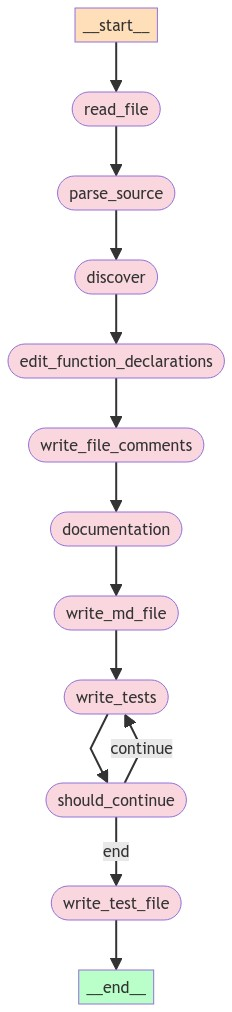

In [13]:
from IPython.display import display, HTML
import base64
from langchain_core.runnables.graph import MermaidDrawMethod

def display_image(image_bytes: bytes, width=300):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))
    
display_image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))

In [14]:
from langgraph.pregel import GraphRecursionError

inputs = {"file_path": "examples/crud.py"}
config = {"recursion_limit": 100}
try:
    result = app.invoke(inputs, config)
    print(result)
except GraphRecursionError:
    print("Graph recursion limit reached.")

/opt/homebrew/Caskroom/miniconda/base/envs/ai/lib/python3.11/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ai/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Summarizing text:
/// Documentation of all methods and properties in the current type, should not be included in final documentation:
///
///     Initializes an object with basic attributes.
/// 
///     This method sets the initial state of the object by assigning values to its attributes: id, name, and description.
///     
///     Args:
///         self (object): The object being initialized. This is a required parameter that refers to the current instance of the class.
///         id (int or str): A unique identifier for the object. This value should be a string or integer type that represents the object's ID.
///         name (str): The name of the object. This value should be a string type that represents the object's name.
///         description (str, optional): A brief description of the object. This value is optional and defaults to None if not provided.
/// 
///     Returns:
///         None: This method does not return any values. It simply initializes the object with the g

In [ ]:
inputs = {"file_path": "examples/test3.swift"}
try:
    result = app.invoke(inputs, config)
    print(result)
except GraphRecursionError:
    print("Graph recursion limit reached.")

/opt/homebrew/Caskroom/miniconda/base/envs/ai/lib/python3.11/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


Summarizing text:
enum TaskManagerError: Error {
    case indexOutOfBounds(String)
    case decodingError(String)
}
Failed to summarize text:
enum TaskManagerError: Error {
    case indexOutOfBounds(String)
    case decodingError(String)
}
Summarizing text:
/// Documentation of all methods and properties in the current type, should not be included in final documentation:
///
/// Holds a string representing the title of an item.
///
/// - note: This property is not a function, but rather a variable that stores a `String` value.
///
/// Indicates whether a task or operation has been completed.
///
/// - note: This property is not implemented and does not have any effect.
///
/// Represents a date that may or may not be set.
///
/// - note: This property is an optional `Date` value, indicating that it may contain no value.
Failed to summarize text:
/// Documentation of all methods and properties in the current type, should not be included in final documentation:
///
/// Holds a string rep